<a href="https://colab.research.google.com/github/abhi4gupta/DMI/blob/main/Assignment2/deepSVDD_oneClassClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import torch
import numpy as np
from torch.utils import data
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from PIL import Image

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1 and classname != 'Conv':
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("Linear") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
class MNIST_loader(data.Dataset):
    """This class is needed to processing batches for the dataloader."""
    def __init__(self, data, target, transform):
        self.data = data
        self.target = target
        self.transform = transform

    def __getitem__(self, index):
        """return transformed items."""
        x = self.data[index]
        y = self.target[index]
        if self.transform:
            x = Image.fromarray(x.numpy(), mode='L')
            x = self.transform(x)
        return x, y

    def __len__(self):
        """number of samples."""
        return len(self.data)


def get_mnist(args, data_dir='/content/drive/MyDrive/Data'):
    """get dataloders"""
    # min, max values for each class after applying GCN (as the original implementation)
    min_max = [(-0.8826567065619495, 9.001545489292527),
                (-0.6661464580883915, 20.108062262467364),
                (-0.7820454743183202, 11.665100841080346),
                (-0.7645772083211267, 12.895051191467457),
                (-0.7253923114302238, 12.683235701611533),
                (-0.7698501867861425, 13.103278415430502),
                (-0.778418217980696, 10.457837397569108),
                (-0.7129780970522351, 12.057777597673047),
                (-0.8280402650205075, 10.581538445782988),
                (-0.7369959242164307, 10.697039838804978)]

    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Lambda(lambda x: global_contrast_normalization(x)),
                                    transforms.Normalize([min_max[args.normal_class][0]],
                                                         [min_max[args.normal_class][1] \
                                                         -min_max[args.normal_class][0]])])
    train = datasets.MNIST(root=data_dir, train=True, download=True)
    test = datasets.MNIST(root=data_dir, train=False, download=True)

    x_train = train.data
    y_train = train.targets

    x_train = x_train[np.where(y_train==args.normal_class)]
    y_train = y_train[np.where(y_train==args.normal_class)]
                                    
    data_train = MNIST_loader(x_train, y_train, transform)
    dataloader_train = DataLoader(data_train, batch_size=args.batch_size, 
                                  shuffle=True, num_workers=0)
    
    x_test = test.data
    y_test = test.targets
    y_test = np.where(y_test==args.normal_class, 0, 1)
    data_test = MNIST_loader(x_test, y_test, transform)
    dataloader_test = DataLoader(data_test, batch_size=args.batch_size, 
                                  shuffle=True, num_workers=0)
    return dataloader_train, dataloader_test

def global_contrast_normalization(x):
    """Apply global contrast normalization to tensor. """
    mean = torch.mean(x)  # mean over all features (pixels) per sample
    x -= mean
    x_scale = torch.mean(torch.abs(x))
    x /= x_scale
    return x

In [ ]:
!pip install barbar

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
import numpy as np
from barbar import Bar
class network(nn.Module):
    def __init__(self, z_dim=32):
        super(network, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)

        self.conv1 = nn.Conv2d(1, 8, 5, bias=False, padding=2)
        self.bn1 = nn.BatchNorm2d(8, eps=1e-04, affine=False)
        self.conv2 = nn.Conv2d(8, 4, 5, bias=False, padding=2)
        self.bn2 = nn.BatchNorm2d(4, eps=1e-04, affine=False)
        self.fc1 = nn.Linear(4 * 7 * 7, z_dim, bias=False)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(F.leaky_relu(self.bn1(x)))
        x = self.conv2(x)
        x = self.pool(F.leaky_relu(self.bn2(x)))
        x = x.view(x.size(0), -1)
        return self.fc1(x)


class autoencoder(nn.Module):
    def __init__(self, z_dim=32):
        super(autoencoder, self).__init__()
        self.z_dim = z_dim
        self.pool = nn.MaxPool2d(2, 2)

        self.conv1 = nn.Conv2d(1, 8, 5, bias=False, padding=2)
        self.bn1 = nn.BatchNorm2d(8, eps=1e-04, affine=False)
        self.conv2 = nn.Conv2d(8, 4, 5, bias=False, padding=2)
        self.bn2 = nn.BatchNorm2d(4, eps=1e-04, affine=False)
        self.fc1 = nn.Linear(4 * 7 * 7, z_dim, bias=False)

        self.deconv1 = nn.ConvTranspose2d(2, 4, 5, bias=False, padding=2)
        self.bn3 = nn.BatchNorm2d(4, eps=1e-04, affine=False)
        self.deconv2 = nn.ConvTranspose2d(4, 8, 5, bias=False, padding=3)
        self.bn4 = nn.BatchNorm2d(8, eps=1e-04, affine=False)
        self.deconv3 = nn.ConvTranspose2d(8, 1, 5, bias=False, padding=2)
        
    def encode(self, x):
        x = self.conv1(x)
        x = self.pool(F.leaky_relu(self.bn1(x)))
        x = self.conv2(x)
        x = self.pool(F.leaky_relu(self.bn2(x)))
        x = x.view(x.size(0), -1)
        return self.fc1(x)
   
    def decode(self, x):
        x = x.view(x.size(0), int(self.z_dim / 16), 4, 4)
        x = F.interpolate(F.leaky_relu(x), scale_factor=2)
        x = self.deconv1(x)
        x = F.interpolate(F.leaky_relu(self.bn3(x)), scale_factor=2)
        x = self.deconv2(x)
        x = F.interpolate(F.leaky_relu(self.bn4(x)), scale_factor=2)
        x = self.deconv3(x)
        return torch.sigmoid(x)
        

    def forward(self, x):
        z = self.encode(x)
        x_hat = self.decode(z)
        return x_hat





class TrainerDeepSVDD:
    def __init__(self, args, data, device):
        self.args = args
        self.train_loader, self.test_loader = data
        self.device = device
    

    def pretrain(self):
        """ Pretraining the weights for the deep SVDD network using autoencoder"""
        ae = autoencoder(self.args.latent_dim).to(self.device)
        ae.apply(weights_init_normal)
        optimizer = optim.Adam(ae.parameters(), lr=self.args.lr_ae,
                               weight_decay=self.args.weight_decay_ae)
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, 
                    milestones=self.args.lr_milestones, gamma=0.1)
        
        ae.train()
        for epoch in range(self.args.num_epochs_ae):
            total_loss = 0
            for x, _ in Bar(self.train_loader):
                x = x.float().to(self.device)
                
                optimizer.zero_grad()
                x_hat = ae(x)
                reconst_loss = torch.mean(torch.sum((x_hat - x) ** 2, dim=tuple(range(1, x_hat.dim()))))
                reconst_loss.backward()
                optimizer.step()
                
                total_loss += reconst_loss.item()
            scheduler.step()
            print('Pretraining Autoencoder... Epoch: {}, Loss: {:.3f}'.format(
                   epoch, total_loss/len(self.train_loader)))
        self.save_weights_for_DeepSVDD(ae, self.train_loader) 
    

    def save_weights_for_DeepSVDD(self, model, dataloader):
        """Initialize Deep SVDD weights using the encoder weights of the pretrained autoencoder."""
        c = self.set_c(model, dataloader)
        net = network(self.args.latent_dim).to(self.device)
        state_dict = model.state_dict()
        net.load_state_dict(state_dict, strict=False)
        torch.save({'center': c.cpu().data.numpy().tolist(),
                    'net_dict': net.state_dict()}, '/content/drive/MyDrive/weights/pretrained_parameters.pth')
    

    def set_c(self, model, dataloader, eps=0.1):
        """Initializing the center for the hypersphere"""
        model.eval()
        z_ = []
        with torch.no_grad():
            for x, _ in dataloader:
                x = x.float().to(self.device)
                z = model.encode(x)
                z_.append(z.detach())
        z_ = torch.cat(z_)
        c = torch.mean(z_, dim=0)
        c[(abs(c) < eps) & (c < 0)] = -eps
        c[(abs(c) < eps) & (c > 0)] = eps
        return c


    def train(self):
        """Training the Deep SVDD model"""
        net = network().to(self.device)
        
        if self.args.pretrain==True:
            state_dict = torch.load('/content/drive/MyDrive/weights/pretrained_parameters.pth')
            net.load_state_dict(state_dict['net_dict'])
            c = torch.Tensor(state_dict['center']).to(self.device)
        else:
            net.apply(weights_init_normal)
            c = torch.randn(self.args.latent_dim).to(self.device)
        
        optimizer = optim.Adam(net.parameters(), lr=self.args.lr,
                               weight_decay=self.args.weight_decay)
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, 
                    milestones=self.args.lr_milestones, gamma=0.1)

        net.train()
        for epoch in range(self.args.num_epochs):
            total_loss = 0
            for x, _ in Bar(self.train_loader):
                x = x.float().to(self.device)

                optimizer.zero_grad()
                z = net(x)
                loss = torch.mean(torch.sum((z - c) ** 2, dim=1))
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
            scheduler.step()
            print('Training Deep SVDD... Epoch: {}, Loss: {:.3f}'.format(
                   epoch, total_loss/len(self.train_loader)))
        self.net = net
        self.c = c

def eval(net, c, dataloader, device):
    """Testing the Deep SVDD model"""

    scores = []
    labels = []
    net.eval()
    print('Testing...')
    with torch.no_grad():
        for x, y in dataloader:
            x = x.float().to(device)
            z = net(x)
            score = torch.sum((z - c) ** 2, dim=1)

            scores.append(score.detach().cpu())
            labels.append(y.cpu())
    labels, scores = torch.cat(labels).numpy(), torch.cat(scores).numpy()
    print('ROC AUC score: {:.2f}'.format(roc_auc_score(labels, scores)*100))
    return labels, scores

class Args:
  def __init__(self, nclass):
    self.num_epochs=20
    self.num_epochs_ae=20
    self.patience=50
    self.lr=1e-4
    self.weight_decay=0.5e-6
    self.weight_decay_ae=0.5e-3
    self.lr_ae=1e-4
    self.lr_milestones=[50]
    self.batch_size=200
    self.pretrain=True
    self.latent_dim=32
    self.normal_class=nclass


nscores=[]
inscores=[]
outscores=[] 
for i in range(10):
  args = Args(i)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  data = get_mnist(args)
  deep_SVDD = TrainerDeepSVDD(args, data, device)
  if args.pretrain:
      deep_SVDD.pretrain()
  deep_SVDD.train()
  print("test for class  ",i,".....")
  labels, scores = eval(deep_SVDD.net, deep_SVDD.c, data[1], device)
  nscores.append(roc_auc_score(labels, scores)*100)
  inscores.append(scores[np.where(labels==0)[0]])
  outscores.append(scores[np.where(labels==1)[0]])


5923/5923: [==============================>.] - ETA 0.2s
Pretraining Autoencoder... Epoch: 0, Loss: 136.714
5923/5923: [==============================>.] - ETA 0.2s
Pretraining Autoencoder... Epoch: 1, Loss: 104.588
5923/5923: [==============================>.] - ETA 0.2s
Pretraining Autoencoder... Epoch: 2, Loss: 78.497
5923/5923: [==============================>.] - ETA 0.2s
Pretraining Autoencoder... Epoch: 3, Loss: 58.625
5923/5923: [==============================>.] - ETA 0.2s
Pretraining Autoencoder... Epoch: 4, Loss: 44.314
5923/5923: [==============================>.] - ETA 0.2s
Pretraining Autoencoder... Epoch: 5, Loss: 34.643
5923/5923: [==============================>.] - ETA 0.2s
Pretraining Autoencoder... Epoch: 6, Loss: 28.044
5923/5923: [==============================>.] - ETA 0.2s
Pretraining Autoencoder... Epoch: 7, Loss: 23.422
5923/5923: [==============================>.] - ETA 0.2s
Pretraining Autoencoder... Epoch: 8, Loss: 20.087
5923/5923: [=======================

In [ ]:
for i in range(10):
  print("ROC scores for class ",i," is: ",nscores[i])

ROC scores for class  0  is:  98.79004706095299
ROC scores for class  1  is:  99.60754439450295
ROC scores for class  2  is:  91.3406906727797
ROC scores for class  3  is:  90.24187491051664
ROC scores for class  4  is:  92.38666816626986
ROC scores for class  5  is:  85.27766453775423
ROC scores for class  6  is:  97.23715100812308
ROC scores for class  7  is:  95.31597221619877
ROC scores for class  8  is:  94.77695282303326
ROC scores for class  9  is:  95.8508558112126


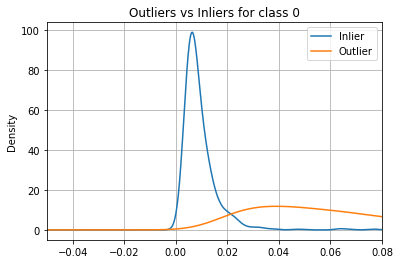

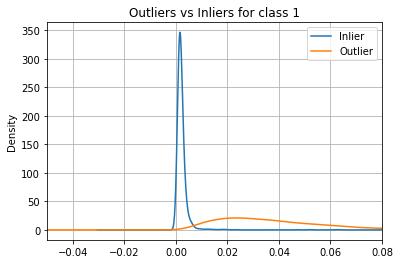

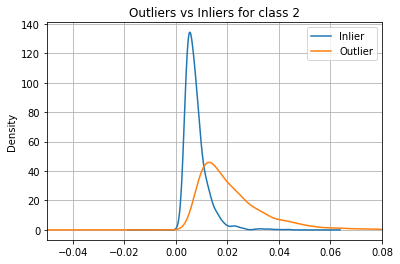

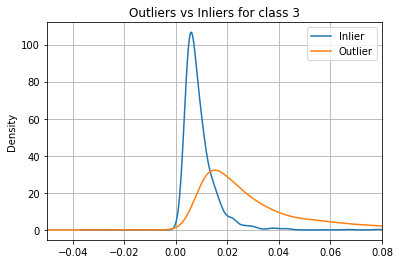

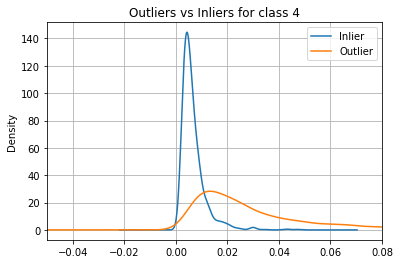

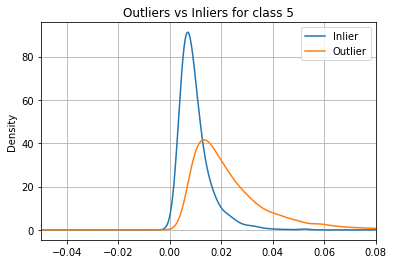

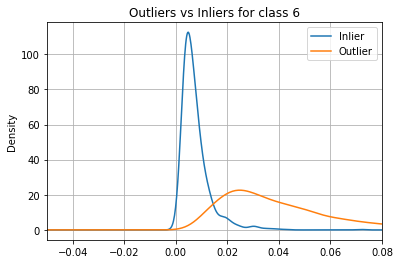

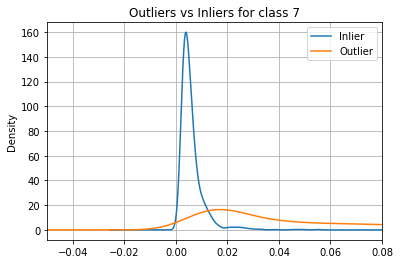

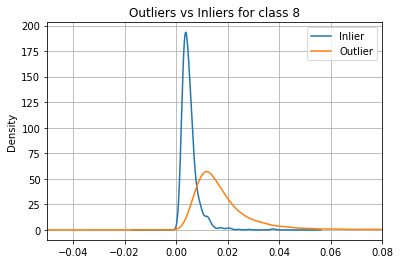

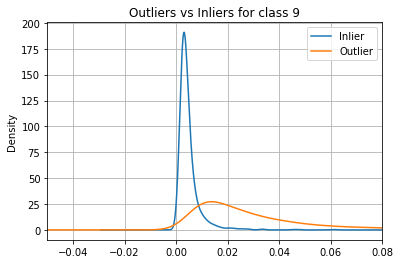

In [ ]:
for i in range(10):
  in_ = pd.DataFrame(inscores[i], columns=['Inlier'])
  out_ = pd.DataFrame(outscores[i], columns=['Outlier'])
  fig, ax = plt.subplots()
  in_.plot.kde(ax=ax, legend=True, title='Outliers vs Inliers for class '+str(i))
  out_.plot.kde(ax=ax, legend=True)
  plt.xlim(-0.05, 0.08)
  ax.grid(axis='x')
  ax.grid(axis='y')
  plt.show()